In [12]:
function cost(x1,y1,x2,y2)
    return  (x1-x2)^2 + (y1-y2)^2 
end;

In [13]:
A = Array{Int}(undef, N, 0)
c = Vector{Float64}(undef, 0)
for row1 in eachrow(inters)
    for row2 in eachrow(inters)
        if row1[:IntersectionID] != row2[:IntersectionID]
            e = zeros(Int8, N)
            e[row1[:IntersectionID]] = 1
            e[row2[:IntersectionID]] = -1
            A = [A e]
            push!(c,cost(row1[:Lat],row1[:Lon],row2[:Lat],row2[:Lon]))
        end
    end
end

In [14]:
m = Model(with_optimizer(Clp.Optimizer))
set_silent(m)
numFlows = nrow(filteredFlow)
@variable(m, X[1:M,1:numFlows]>=0)
for (i, row) in enumerate(eachrow(filteredFlow))
    b = zeros(Int64, N)
    b[reIndex[row[:FromInt]]] = row[:Flow]
    b[reIndex[row[:ToInt]]] = -row[:Flow]
    @constraint(m, A*(X[:,i]) .== b)
end
@expression(m, x,  sum(X',dims=1) )
@objective(m,Min,dot(x,c));

In [15]:
optimize!(m)

In [16]:
solution_summary(m)

* Solver : Clp

* Status
  Termination status : OPTIMAL
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Message from the solver:
  "0 - optimal"

* Candidate solution
  Objective value      : 357.8368192036825

* Work counters
  Solve time (sec)   : 8.64762


In [17]:
x_opt = value.(x);

In [18]:
sum(x_opt.!= 0)

186

In [19]:
numFlows

1468

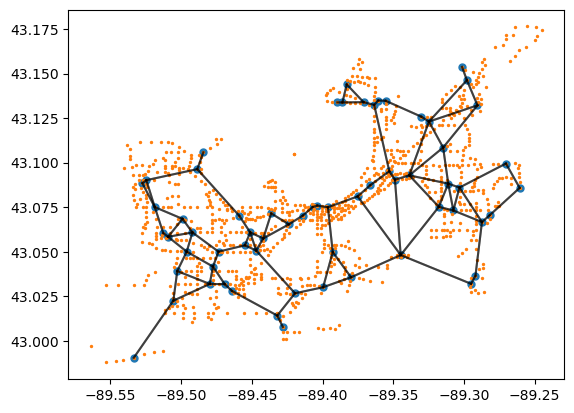

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/ankurgarg/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [20]:
X = round.(inters[!,:X],digits = 6)
Y = round.(inters[!,:Y],digits = 6)
scatter(X,Y,s=25);
i = 1
for row1 in eachrow(inters)
    for row2 in eachrow(inters)
        if row1[:IntersectionID] != row2[:IntersectionID]
            if(x_opt[i]>0)
                plot((row1[:Lon], row2[:Lon]),(row1[:Lat], row2[:Lat]),color = "black",alpha = .5)
                #println("$(row1[:IntersectionID]) $(row2[:IntersectionID]) $(x_opt[i])")
            end
            i+=1
        end
    end
end
X = round.(raw4[!,:X],digits = 6)
Y = round.(raw4[!,:Y],digits = 6)
scatter(X,Y,s=2);

In [21]:
A*x_opt' 

64×1 Matrix{Float64}:
  666.0
  -64.0
  -77.0
 -144.0
 -354.0
 -605.0
 -129.0
 -379.0
  -78.0
 -311.0
 -283.0
  -44.0
  -29.0
    ⋮
  -56.0
 -134.0
  -93.0
  -31.0
   -5.0
  -13.0
   26.0
   51.0
 -200.0
  -43.0
  -33.0
   -7.0